## Importing libraries

In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from dotenv import load_dotenv
from mpl_toolkits.mplot3d import Axes3D
import os
import zipfile
import shutil
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler,StandardScaler


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")

## Reading datasets

### Feature 1 : Weighted Parallel Score

In [17]:
top_20_overlap_service = pd.read_csv("../datasets/filtered_final_results.csv").head(21)
top_20_overlap_service['ServiceNo'] = top_20_overlap_service['ServiceNo'].astype(str)
print(top_20_overlap_service.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 21 non-null     int64  
 1   ServiceNo                  21 non-null     object 
 2   TotalStops                 21 non-null     int64  
 3   WeightedParallelScore      21 non-null     float64
 4   TrainLineParallelScores    21 non-null     object 
 5   LongestConsecutiveLengths  21 non-null     object 
 6   UniqueParallelCounts       21 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.3+ KB
None


In [18]:
#Removing bus service 400 as the pv volume is missing for the entire bus route
top_20_overlap_service.dropna()

,Unnamed: 0,ServiceNo,TotalStops,WeightedParallelScore,TrainLineParallelScores,LongestConsecutiveLengths,UniqueParallelCounts
0,254,67,163,0.780972,"{'BP': [0.12405063291139241, 0.116666666666666...","{'BP': [4, 4], 'DT': [23, 25], 'EW': [18, 20],...","{'BP': [5, 5], 'DT': [39, 45], 'EW': [18, 20],..."
1,219,48,105,0.682618,"{'CC': [0.2037735849056604, 0.2269230769230769...","{'CC': [4, 4], 'DT': [14, 13], 'EW': [1, 2], '...","{'CC': [6, 7], 'DT': [14, 15], 'EW': [2, 4], '..."
2,12,107,79,0.656574,"{'DT': [0.16499999999999998, 0.112820512820512...","{'DT': [3, 2], 'EW': [7, 7], 'NE': [10, 11], '...","{'DT': [3, 2], 'EW': [8, 9], 'NE': [13, 14], '..."
3,159,2,131,0.627249,"{'DT': [0.0782608695652174, 0.0870967741935483...","{'DT': [2, 2], 'EW': [29, 27], 'NE': [4, 3]}","{'DT': [3, 3], 'EW': [32, 28], 'NE': [5, 3]}"
4,54,133,86,0.584443,"{'CC': [0.1, 0.05238095238095238], 'CE': [0.1,...","{'CC': [2, 1], 'CE': [2, 1], 'DT': [1, 1], 'EW...","{'CC': [2, 1], 'CE': [2, 1], 'DT': [3, 2], 'EW..."
5,113,170,130,0.571120,"{'DT': [1.0151515151515151, 0.9781249999999999...","{'DT': [25, 23], 'NS': [1, 1], 'BP': [1]}","{'DT': [37, 35], 'NS': [1, 1], 'BP': [1]}"
6,145,190,64,0.549306,"{'BP': [0.09696969696969697, 0.103225806451612...","{'BP': [1, 1], 'CC': [2, 1], 'DT': [2, 1], 'EW...","{'BP': [2, 2], 'CC': [2, 2], 'DT': [2, 1], 'EW..."
7,196,36,61,0.546066,"{'CC': [0.1737704918032787], 'CG': [0.07213114...","{'CC': [3], 'CG': [2], 'NS': [5], 'TE': [11]}","{'CC': [7], 'CG': [2], 'NS': [10], 'TE': [22]}"
8,207,400,21,0.541905,"{'DT': [0.3047619047619048], 'EW': [0.2], 'NS'...","{'DT': [2], 'EW': [1], 'NS': [3], 'TE': [2]}","{'DT': [4], 'EW': [3], 'NS': [4], 'TE': [3]}"
9,176,26,64,0.536735,"{'DT': [0.06470588235294118, 0.073333333333333...","{'DT': [1, 1], 'EW': [14, 12], 'NE': [1]}","{'DT': [1, 1], 'EW': [14, 12], 'NE': [1]}"


In [19]:
top_50_overlap_service = pd.read_csv('../datasets/filtered_final_results.csv').head(51)
top_50_overlap_service['ServiceNo'] = top_50_overlap_service['ServiceNo'].astype(str)

In [20]:
top_50_overlap_service.dropna()

,Unnamed: 0,ServiceNo,TotalStops,WeightedParallelScore,TrainLineParallelScores,LongestConsecutiveLengths,UniqueParallelCounts
0,254,67,163,0.780972,"{'BP': [0.12405063291139241, 0.116666666666666...","{'BP': [4, 4], 'DT': [23, 25], 'EW': [18, 20],...","{'BP': [5, 5], 'DT': [39, 45], 'EW': [18, 20],..."
1,219,48,105,0.682618,"{'CC': [0.2037735849056604, 0.2269230769230769...","{'CC': [4, 4], 'DT': [14, 13], 'EW': [1, 2], '...","{'CC': [6, 7], 'DT': [14, 15], 'EW': [2, 4], '..."
2,12,107,79,0.656574,"{'DT': [0.16499999999999998, 0.112820512820512...","{'DT': [3, 2], 'EW': [7, 7], 'NE': [10, 11], '...","{'DT': [3, 2], 'EW': [8, 9], 'NE': [13, 14], '..."
3,159,2,131,0.627249,"{'DT': [0.0782608695652174, 0.0870967741935483...","{'DT': [2, 2], 'EW': [29, 27], 'NE': [4, 3]}","{'DT': [3, 3], 'EW': [32, 28], 'NE': [5, 3]}"
4,54,133,86,0.584443,"{'CC': [0.1, 0.05238095238095238], 'CE': [0.1,...","{'CC': [2, 1], 'CE': [2, 1], 'DT': [1, 1], 'EW...","{'CC': [2, 1], 'CE': [2, 1], 'DT': [3, 2], 'EW..."
5,113,170,130,0.571120,"{'DT': [1.0151515151515151, 0.9781249999999999...","{'DT': [25, 23], 'NS': [1, 1], 'BP': [1]}","{'DT': [37, 35], 'NS': [1, 1], 'BP': [1]}"
6,145,190,64,0.549306,"{'BP': [0.09696969696969697, 0.103225806451612...","{'BP': [1, 1], 'CC': [2, 1], 'DT': [2, 1], 'EW...","{'BP': [2, 2], 'CC': [2, 2], 'DT': [2, 1], 'EW..."
7,196,36,61,0.546066,"{'CC': [0.1737704918032787], 'CG': [0.07213114...","{'CC': [3], 'CG': [2], 'NS': [5], 'TE': [11]}","{'CC': [7], 'CG': [2], 'NS': [10], 'TE': [22]}"
8,207,400,21,0.541905,"{'DT': [0.3047619047619048], 'EW': [0.2], 'NS'...","{'DT': [2], 'EW': [1], 'NS': [3], 'TE': [2]}","{'DT': [4], 'EW': [3], 'NS': [4], 'TE': [3]}"
9,176,26,64,0.536735,"{'DT': [0.06470588235294118, 0.073333333333333...","{'DT': [1, 1], 'EW': [14, 12], 'NE': [1]}","{'DT': [1, 1], 'EW': [14, 12], 'NE': [1]}"


### Feature 2: Passenger Volume

In [21]:
#result retrieved from eda_passenger_volume.ipynb
pv_trend = pd.read_csv("../datasets/pv_eda/routes_pv_trend.csv")
print(pv_trend.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ServiceNo     400 non-null    object 
 1   2024-07       400 non-null    float64
 2   2024-08       400 non-null    float64
 3   2024-09       400 non-null    float64
 4   Trend         400 non-null    object 
 5   Trend_Binary  400 non-null    int64  
 6   Change        400 non-null    float64
 7   Average       400 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 25.1+ KB
None


In [22]:
top_20_pv_trend = pd.merge(top_20_overlap_service, pv_trend, on="ServiceNo", how="inner")
print(top_20_pv_trend.head())

   Unnamed: 0 ServiceNo  TotalStops  WeightedParallelScore  \
0         254        67         163               0.780972   
1         219        48         105               0.682618   
2          12       107          79               0.656574   
3         159         2         131               0.627249   
4          54       133          86               0.584443   

                             TrainLineParallelScores  \
0  {'BP': [0.12405063291139241, 0.116666666666666...   
1  {'CC': [0.2037735849056604, 0.2269230769230769...   
2  {'DT': [0.16499999999999998, 0.112820512820512...   
3  {'DT': [0.0782608695652174, 0.0870967741935483...   
4  {'CC': [0.1, 0.05238095238095238], 'CE': [0.1,...   

                           LongestConsecutiveLengths  \
0  {'BP': [4, 4], 'DT': [23, 25], 'EW': [18, 20],...   
1  {'CC': [4, 4], 'DT': [14, 13], 'EW': [1, 2], '...   
2  {'DT': [3, 2], 'EW': [7, 7], 'NE': [10, 11], '...   
3       {'DT': [2, 2], 'EW': [29, 27], 'NE': [4, 3]}   
4  {'CC': 

In [23]:
top_20_pv_trend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 20 non-null     int64  
 1   ServiceNo                  20 non-null     object 
 2   TotalStops                 20 non-null     int64  
 3   WeightedParallelScore      20 non-null     float64
 4   TrainLineParallelScores    20 non-null     object 
 5   LongestConsecutiveLengths  20 non-null     object 
 6   UniqueParallelCounts       20 non-null     object 
 7   2024-07                    20 non-null     float64
 8   2024-08                    20 non-null     float64
 9   2024-09                    20 non-null     float64
 10  Trend                      20 non-null     object 
 11  Trend_Binary               20 non-null     int64  
 12  Change                     20 non-null     float64
 13  Average                    20 non-null     float64
d

In [24]:
top_50_pv_trend = pd.merge(top_50_overlap_service, pv_trend, on="ServiceNo", how="inner")
print(top_50_pv_trend.head())

   Unnamed: 0 ServiceNo  TotalStops  WeightedParallelScore  \
0         254        67         163               0.780972   
1         219        48         105               0.682618   
2          12       107          79               0.656574   
3         159         2         131               0.627249   
4          54       133          86               0.584443   

                             TrainLineParallelScores  \
0  {'BP': [0.12405063291139241, 0.116666666666666...   
1  {'CC': [0.2037735849056604, 0.2269230769230769...   
2  {'DT': [0.16499999999999998, 0.112820512820512...   
3  {'DT': [0.0782608695652174, 0.0870967741935483...   
4  {'CC': [0.1, 0.05238095238095238], 'CE': [0.1,...   

                           LongestConsecutiveLengths  \
0  {'BP': [4, 4], 'DT': [23, 25], 'EW': [18, 20],...   
1  {'CC': [4, 4], 'DT': [14, 13], 'EW': [1, 2], '...   
2  {'DT': [3, 2], 'EW': [7, 7], 'NE': [10, 11], '...   
3       {'DT': [2, 2], 'EW': [29, 27], 'NE': [4, 3]}   
4  {'CC': 

In [25]:
# Normalize 'Change' and 'Average' by 'TotalStops'
top_20_pv_trend['Change_Normalized'] = top_20_pv_trend['Change'] / top_20_pv_trend['TotalStops']
top_20_pv_trend['Average_Normalized'] = top_20_pv_trend['Average'] / top_20_pv_trend['TotalStops']

# Calculate z-score for 'Change_Normalized' across the entire dataset
change_mean = top_20_pv_trend['Change_Normalized'].mean()
change_std = top_20_pv_trend['Change_Normalized'].std()
top_20_pv_trend['Change_Standardized'] = (top_20_pv_trend['Change_Normalized'] - change_mean) / change_std

# Adjust signs based on 'Trend'
top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'] = \
   - np.abs(top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'])

top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'] = \
    np.abs(top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'])

# Scale 'Average_Normalized' to the range 0-1 for the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
top_20_pv_trend['Average_Standardized'] = scaler.fit_transform(top_20_pv_trend[['Average_Normalized']])

top_20_pv_trend = top_20_pv_trend[['ServiceNo', 'TotalStops', 'WeightedParallelScore', 
                                   'Trend_Binary', 'Change_Standardized', 'Average_Standardized']]

# Preview the resulting DataFrame
print(top_20_pv_trend)

   ServiceNo  TotalStops  WeightedParallelScore  Trend_Binary  \
0         67         163               0.780972             0   
1         48         105               0.682618             0   
2        107          79               0.656574             0   
3          2         131               0.627249             0   
4        133          86               0.584443             0   
5        170         130               0.571120             0   
6        190          64               0.549306             0   
7         36          61               0.546066             1   
8         26          64               0.536735             0   
9        851         108               0.492411             0   
10        13         129               0.484494             0   
11       960          92               0.475978             0   
12        80         118               0.473491             0   
13       147         146               0.472751             0   
14       852          96 

In [138]:
# Normalize 'Change' and 'Average' by 'TotalStops'
top_50_pv_trend['Change_Normalized'] = top_50_pv_trend['Change'] / top_50_pv_trend['TotalStops']
top_50_pv_trend['Average_Normalized'] = top_50_pv_trend['Average'] / top_50_pv_trend['TotalStops']

# Calculate z-score for 'Change_Normalized' across the entire dataset
change_mean = top_50_pv_trend['Change_Normalized'].mean()
change_std = top_50_pv_trend['Change_Normalized'].std()
top_50_pv_trend['Change_Standardized'] = (top_50_pv_trend['Change_Normalized'] - change_mean) / change_std

# Adjust signs based on 'Trend'
top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'] = \
   - np.abs(top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'])

top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'] = \
    np.abs(top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'])

# Scale 'Average_Normalized' to the range 0-1 for the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
top_50_pv_trend['Average_Standardized'] = scaler.fit_transform(top_50_pv_trend[['Average_Normalized']])

top_50_pv_trend = top_50_pv_trend[['ServiceNo', 'TotalStops', 'WeightedParallelScore', 
                                   'Trend_Binary', 'Change_Standardized', 'Average_Standardized']]

# Preview the resulting DataFrame
print(top_50_pv_trend)

   ServiceNo  TotalStops  WeightedParallelScore  Trend_Binary  \
0         67         163               0.780972             0   
1         48         105               0.682618             0   
2        107          79               0.656574             0   
3          2         131               0.627249             0   
4        133          86               0.584443             0   
5        170         130               0.571120             0   
6        190          64               0.549306             0   
7         36          61               0.546066             1   
8         26          64               0.536735             0   
9        851         108               0.492411             0   
10        13         129               0.484494             0   
11       960          92               0.475978             0   
12        80         118               0.473491             0   
13       147         146               0.472751             0   
14       852          96 

### Feature 3 : Average Distance of bus stops to train stations 

In [26]:
# Result produced from Overlapping_calculation.ipynb under /src
avg_dist_df = pd.read_pickle("../datasets/overlap_results_with_road_distance3.pkl")

In [27]:
top_20_features_try = pd.merge(top_20_pv_trend,avg_dist_df, on = 'ServiceNo')

In [28]:
top_20_features_try 

,ServiceNo,TotalStops,WeightedParallelScore,Trend_Binary,Change_Standardized,Average_Standardized,TotalBusStops,AvgNormalizedDistance,SoftmaxAvgDistance,NormalizedDistances,Category
0,67,163,0.780972,0,-1.203267,0.583099,161,0.737742,0.002022,"{'44009': [[0.6490839987018319, 'NS4', 'North-...",TRUNK
1,48,105,0.682618,0,-0.883289,0.152888,103,0.773233,0.001952,"{'85099': [[0.26772999946453996, 'EW4', 'East-...",TRUNK
2,107,79,0.656574,0,-0.145905,0.310069,77,0.745774,0.002006,"{'64009': [[0.350813999298372, 'NE14', 'North ...",TRUNK
3,2,131,0.627249,0,-0.317594,0.234075,129,0.848269,0.001811,"{'96059': [[0.337453999325092, 'DT34', 'Downto...",TRUNK
4,133,86,0.584443,0,-0.007895,0.346111,84,0.751249,0.001995,"{'54009': [[0.508063998983872, 'NS16', 'North-...",TRUNK
5,170,130,0.571120,0,-0.757153,0.353073,126,0.772111,0.001954,"{'01109': [[0.6014639987970719, 'DT22', 'Downt...",TRUNK
6,190,64,0.549306,0,-0.548577,0.434482,62,0.702800,0.002094,"{'44009': [[0.6490839987018319, 'NS4', 'North-...",TRUNK
7,36,61,0.546066,1,1.493503,0.018647,60,0.668416,0.002167,"{'95129': [[0.0, 'CG2', 'Changi Airport Branch...",TRUNK
8,26,64,0.536735,0,-2.514463,1.000000,62,0.897184,0.001724,"{'80049': [[0.9481579981036838, 'EW10', 'East-...",TRUNK
9,851,108,0.492411,0,-0.286416,0.393639,106,0.774226,0.001950,"{'59009': [[0.43005999913988, 'NS13', 'North-S...",TRUNK


In [15]:
top_20_features = pd.merge(top_20_pv_trend,avg_dist_df, on = 'ServiceNo')
top_20_features = top_20_features[['ServiceNo','WeightedParallelScore','Change_Standardized','AvgNormalizedDistance']]
top_20_features.columns = ['ServiceNo', 'WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']

NameError: name 'top_20_pv_trend' is not defined

In [ ]:
top_50_features = pd.merge(top_50_pv_trend,avg_dist_df, on = 'ServiceNo')
top_50_features = top_50_features[['ServiceNo','WeightedParallelScore','Change_Standardized','AvgNormalizedDistance']]
top_50_features.columns = ['ServiceNo', 'WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']

In [ ]:
# Apply StandardScaler to standardize the features for top 20 bus services
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled_20 = scaler.fit_transform(top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

In [ ]:
# # Apply StandardScaler to standardize the features for top 50 bus services 
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(top_50_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

### Kmeans Clustering Using Top 50 bus services

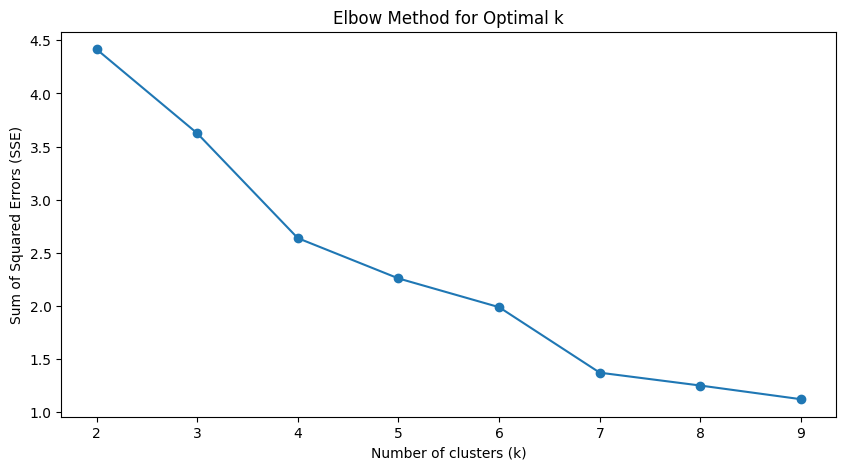

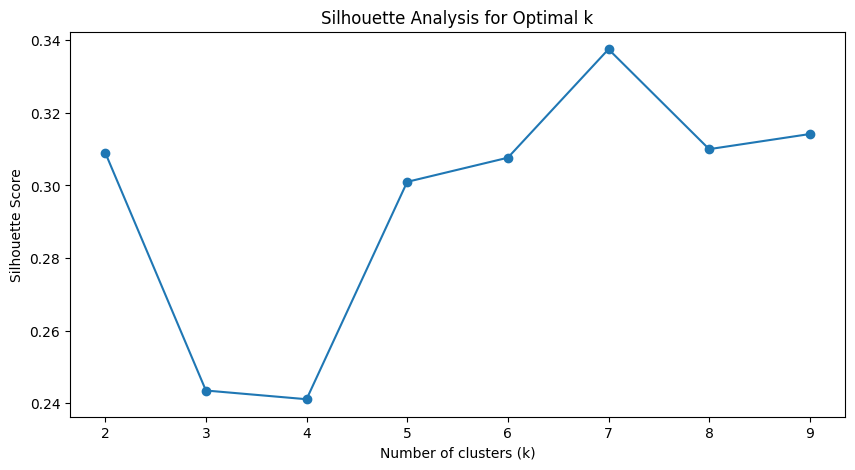

Silhouette score for k=2: 0.309
Silhouette score for k=3: 0.244
Silhouette score for k=4: 0.241
Silhouette score for k=5: 0.301
Silhouette score for k=6: 0.308
Silhouette score for k=7: 0.338
Silhouette score for k=8: 0.310
Silhouette score for k=9: 0.314


In [150]:
# Elbow Method
sse = []  # Sum of squared errors
range_k = range(2, 10)  # Range of k to test

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the SSE for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Analysis
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Print out the silhouette scores for inspection
for i, score in zip(range_k, silhouette_scores):
    print(f"Silhouette score for k={i}: {score:.3f}")

Cluster Centers:
[[0.12766394 0.56694044 0.85693839]
 [0.1410229  0.52982752 0.57236402]
 [0.66763756 0.53047305 0.45015149]
 [0.1469901  0.48008631 0.20150174]
 [0.08902166 0.90325409 0.44074425]
 [0.40162209 0.86701512 0.        ]
 [0.17505019 0.11077352 0.78992959]]
Top 50 bus service with cluster assignments:
   WeightedParallelScore  AvgPVChange  AvgDistanceToMRT  Cluster
0               1.000000     0.359093          0.303042        2
1               0.749462     0.497677          0.458180        2
2               0.683120     0.613202          0.338149        2
3               0.608420     0.604223          0.786181        2
4               0.499380     0.587209          0.362082        2


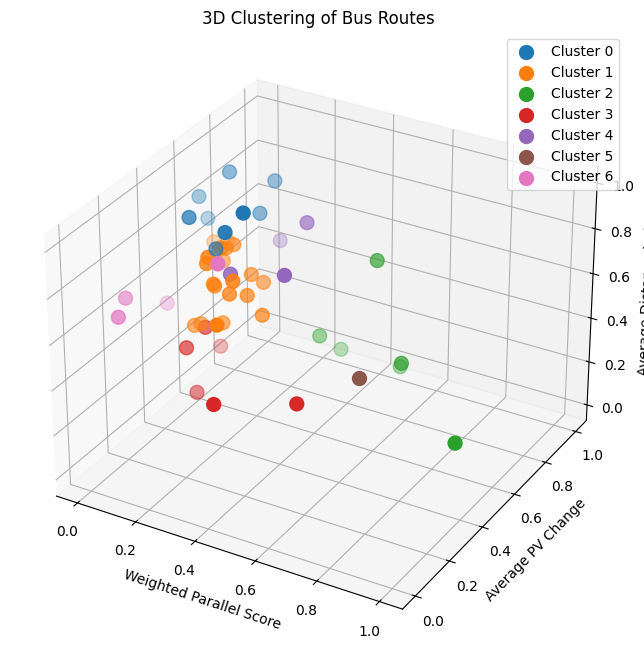

In [ ]:
k = 7 # Optimal number of clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Create a DataFrame to store the results
columns = ['WeightedParallelScore', 'AvgPVChange', 'AvgDistanceToMRT']  # Replace with your actual column names if needed
top_50_features_df = pd.DataFrame(features_scaled, columns=columns)
top_50_features_df['Cluster'] = cluster_labels

# Analyze the clusters
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the first few rows of the DataFrame with cluster assignments
print("Top 50 bus service with cluster assignments:")
print(top_50_features_df.head())


# Create a 3D scatterplots
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(k):
    cluster_data = top_50_features_df[top_50_features_df['Cluster'] == i]
    ax.scatter(
        cluster_data['WeightedParallelScore'], 
        cluster_data['AvgPVChange'], 
        cluster_data['AvgDistanceToMRT'], 
        label=f'Cluster {i}', 
        s=100  # Adjust the size of the dots
    )

ax.set_xlabel('Weighted Parallel Score')
ax.set_ylabel('Average PV Change')
ax.set_zlabel('Average Distance to MRT')
ax.set_title('3D Clustering of Bus Routes')
plt.legend()
plt.show()




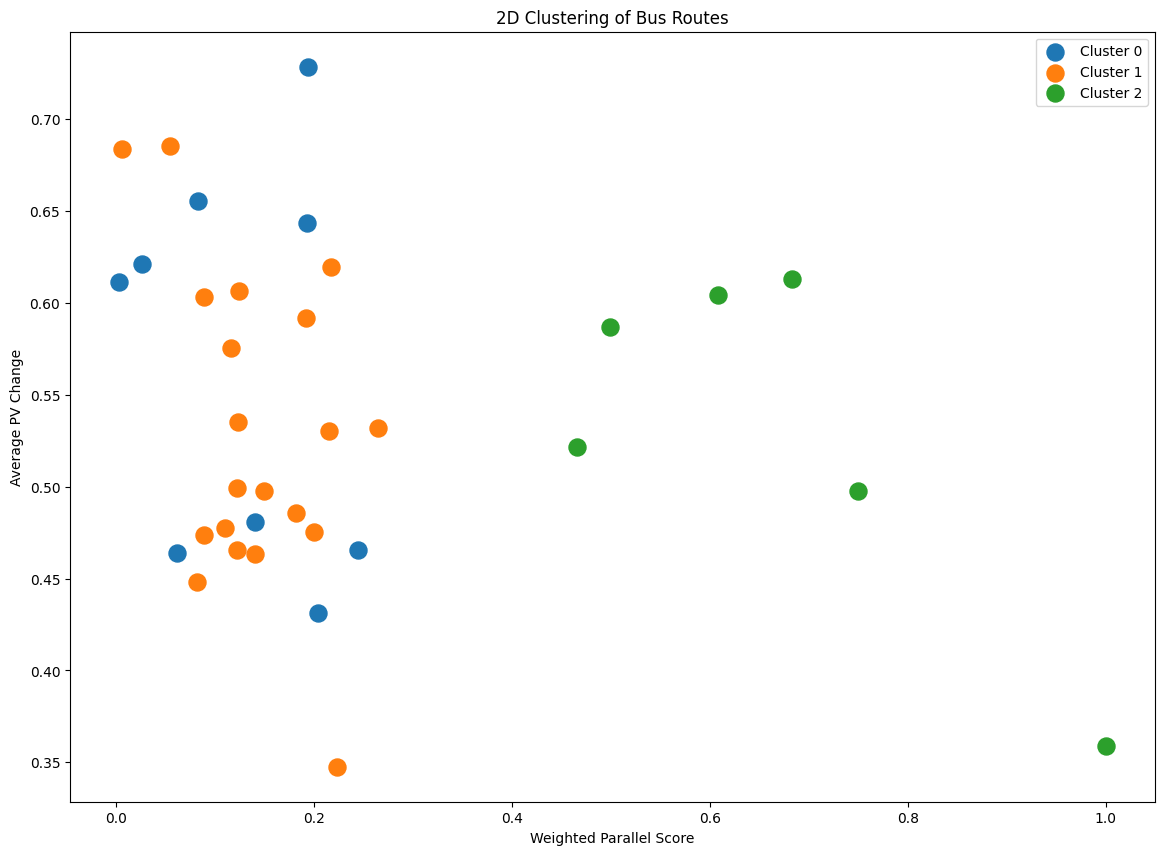

In [ ]:
# 2D Scatter plots
plt.figure(figsize=(14, 10))

# Plot each cluster in 2D
for i in range(k):
    cluster_data = top_50_features_df[top_50_features_df['Cluster'] == i]
    plt.scatter(
        cluster_data['WeightedParallelScore'], 
        cluster_data['AvgPVChange'], 
        label=f'Cluster {i}', 
        s=150  # Adjust the size of the dots for better visibility
    )

plt.xlabel('Weighted Parallel Score')
plt.ylabel('Average PV Change')
plt.title('2D Clustering of Bus Routes')
plt.legend()
plt.show()


In [ ]:
top_50_features.loc[:, 'Clusters_KNN'] = top_50_features_df['Cluster'].values

In [167]:
top_50_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN,Cluster_HC
0,67,0.780972,-1.259335,0.737742,2,1
1,48,0.682618,-0.602706,0.773233,2,1
2,107,0.656574,-0.055335,0.745774,2,1
3,2,0.627249,-0.097881,0.848269,2,1
4,133,0.584443,-0.178495,0.751249,2,1
5,170,0.571120,-0.490143,0.772111,2,1
6,190,0.549306,-0.675090,0.702800,3,0
7,36,0.546066,1.147261,0.668416,5,0
8,26,0.536735,-2.429445,0.897184,6,2
9,851,0.492411,-0.441138,0.774226,1,4


### Kmeans Clustering with top 20 bus services

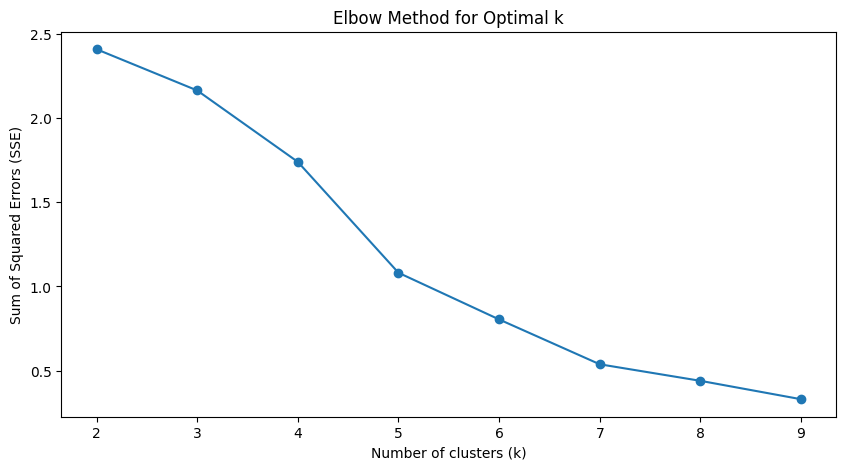

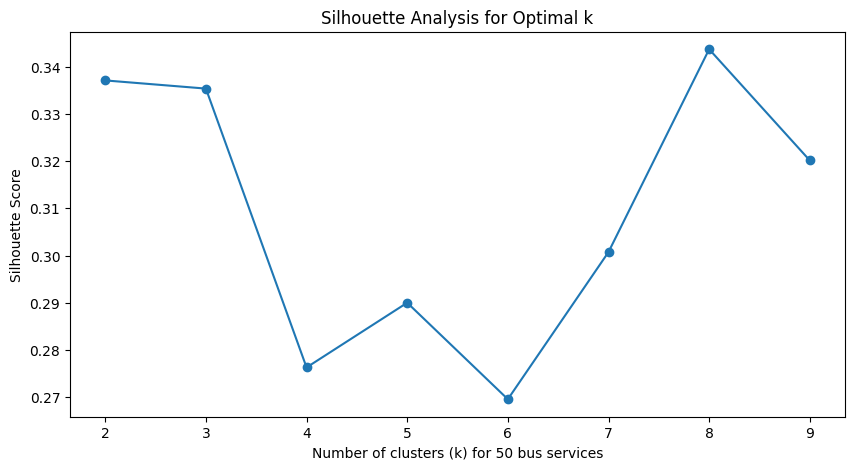

Silhouette score for k=2: 0.337
Silhouette score for k=3: 0.335
Silhouette score for k=4: 0.276
Silhouette score for k=5: 0.290
Silhouette score for k=6: 0.270
Silhouette score for k=7: 0.301
Silhouette score for k=8: 0.344
Silhouette score for k=9: 0.320


In [154]:
# Elbow Method
sse = []  # Sum of squared errors
range_k = range(2, 10)  # Range of k to test

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled_20)
    sse.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the SSE for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Analysis
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled_20)
    silhouette_avg = silhouette_score(features_scaled_20, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k) for 50 bus services')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Print out the silhouette scores for inspection
for i, score in zip(range_k, silhouette_scores):
    print(f"Silhouette score for k={i}: {score:.3f}")

Cluster Centers:
[[0.25937034 1.         0.        ]
 [0.12645472 0.48263698 0.60706644]
 [0.76589688 0.44169774 0.36645689]]
Top 50 bus service with cluster assignments:
   WeightedParallelScore  AvgPVChange  AvgDistanceToMRT  Cluster
0               1.000000     0.327148          0.303042        2
1               0.689902     0.406983          0.458180        2
2               0.607788     0.590963          0.338149        2
3               0.515330     0.548126          0.786181        1
4               0.380368     0.625397          0.362082        1


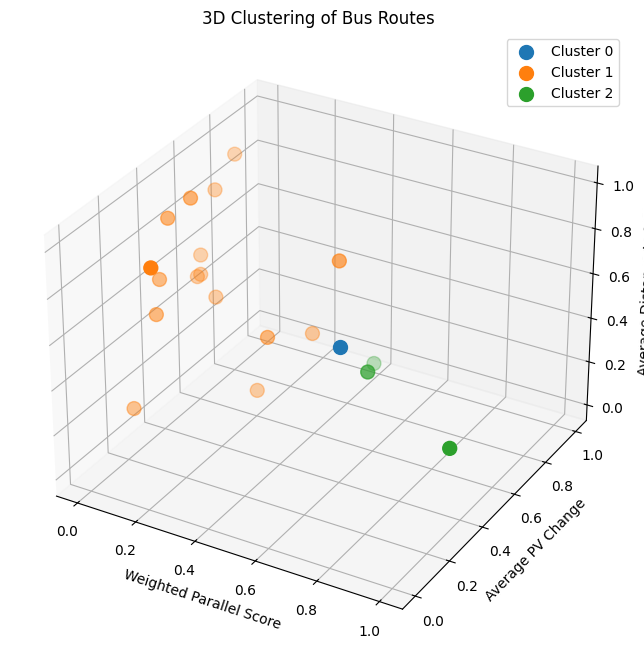

In [ ]:
k = 3  # Optimal number of clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled_20)

# Create a DataFrame to store the results
columns = ['WeightedParallelScore', 'AvgPVChange', 'AvgDistanceToMRT']  # Replace with your actual column names if needed
top_20_features_df = pd.DataFrame(features_scaled_20, columns=columns)
top_20_features_df['Cluster'] = cluster_labels

# Analyze the clusters
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the first few rows of the DataFrame with cluster assignments
print("Top 50 bus service with cluster assignments:")
print(top_20_features_df.head())

# Create a 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(k):
    cluster_data = top_20_features_df[top_20_features_df['Cluster'] == i]
    ax.scatter(
        cluster_data['WeightedParallelScore'], 
        cluster_data['AvgPVChange'], 
        cluster_data['AvgDistanceToMRT'], 
        label=f'Cluster {i}', 
        s=100  # Adjust the size of the dots
    )

ax.set_xlabel('Weighted Parallel Score')
ax.set_ylabel('Average PV Change')
ax.set_zlabel('Average Distance to MRT')
ax.set_title('3D Clustering of Bus Routes')
plt.legend()
plt.show()




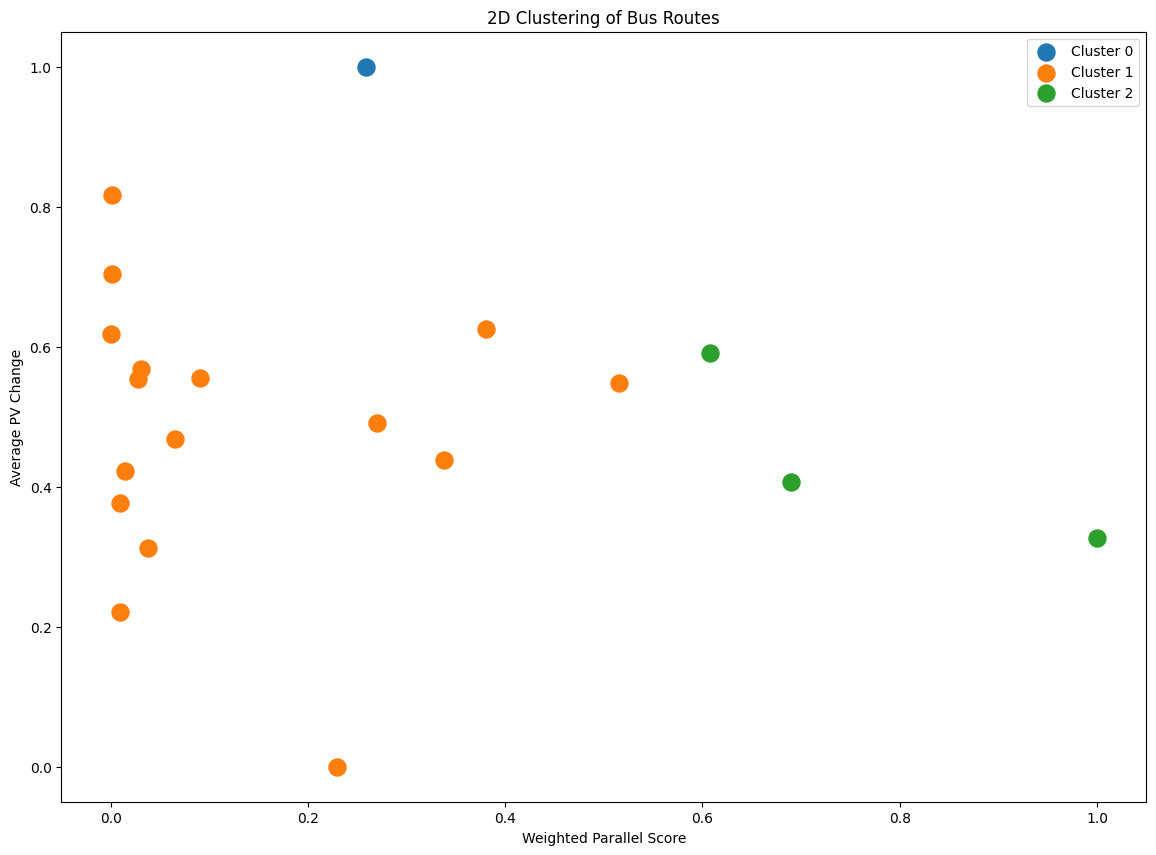

In [173]:
# 2D scatterplots
plt.figure(figsize=(14, 10))

# Plot each cluster in 2D
for i in range(k):
    cluster_data = top_20_features_df[top_20_features_df['Cluster'] == i]
    plt.scatter(
        cluster_data['WeightedParallelScore'], 
        cluster_data['AvgPVChange'], 
        label=f'Cluster {i}', 
        s=150  # Adjust the size of the dots for better visibility
    )

plt.xlabel('Weighted Parallel Score')
plt.ylabel('Average PV Change')
plt.title('2D Clustering of Bus Routes')
plt.legend()
plt.show()


In [174]:
top_20_features.loc[:, 'Clusters_KNN'] = top_20_features_df['Cluster'].values

In [175]:
top_20_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN,Cluster_HC
0,67,0.780972,-1.203267,0.737742,2,0
1,48,0.682618,-0.883289,0.773233,2,0
2,107,0.656574,-0.145905,0.745774,2,0
3,2,0.627249,-0.317594,0.848269,1,0
4,133,0.584443,-0.007895,0.751249,1,3
5,170,0.571120,-0.757153,0.772111,1,3
6,190,0.549306,-0.548577,0.702800,1,3
7,36,0.546066,1.493503,0.668416,0,4
8,26,0.536735,-2.514463,0.897184,1,2
9,851,0.492411,-0.286416,0.774226,1,3


### Correlation Check

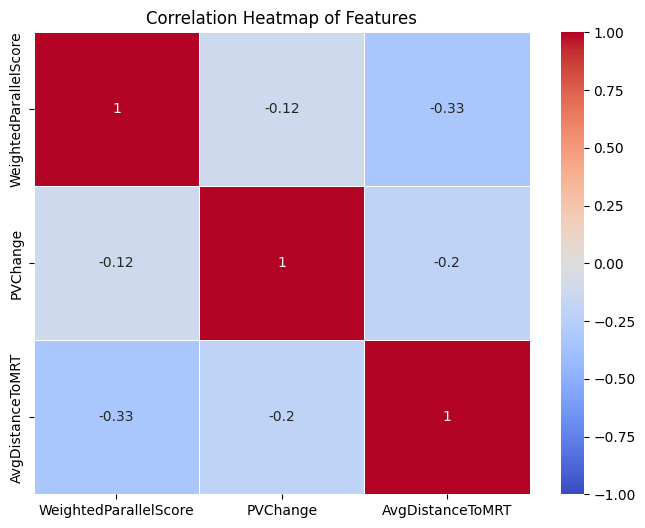

In [176]:
# Select only relevant features for correlation
features = top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']]

# Calculate the correlation matrix
corr_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()


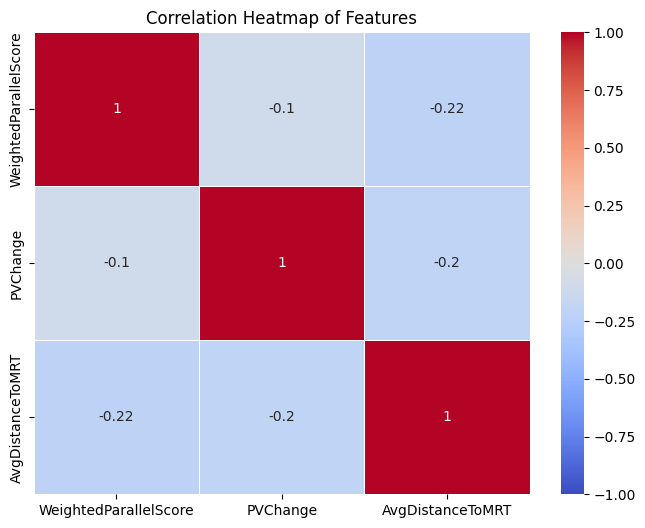

In [177]:
# Select only relevant features for correlation
features = top_50_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']]

# Calculate the correlation matrix
corr_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

### Hierarchical Clustering with top 50 bus services

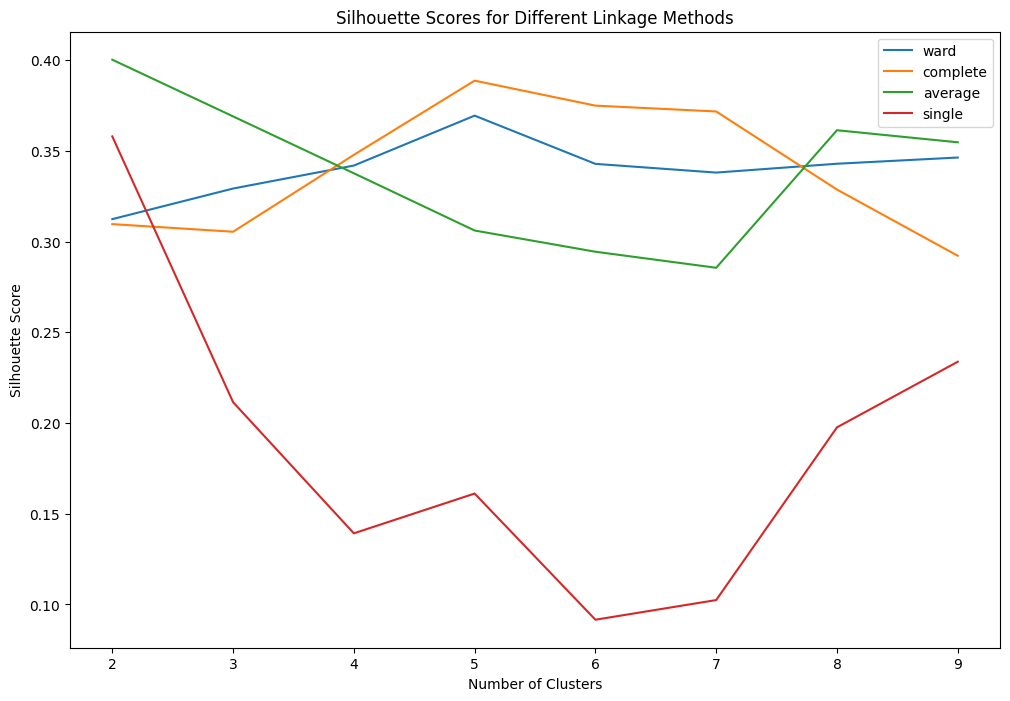

In [159]:
# Test different linkage methods and number of clusters
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores = {}

for method in linkage_methods:
    linked = linkage(features_scaled, method=method)
    silhouette_scores[method] = []

    # Test silhouette score for different number of clusters
    for k in range(2, 10):  # Test from 2 to 10 clusters
        cluster_labels = fcluster(linked, k, criterion='maxclust')
        score = silhouette_score(features_scaled, cluster_labels)
        silhouette_scores[method].append(score)

# Plot silhouette scores for each method
plt.figure(figsize=(12, 8))
for method in silhouette_scores:
    plt.plot(range(2, 10), silhouette_scores[method], label=method)

plt.title("Silhouette Scores for Different Linkage Methods")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

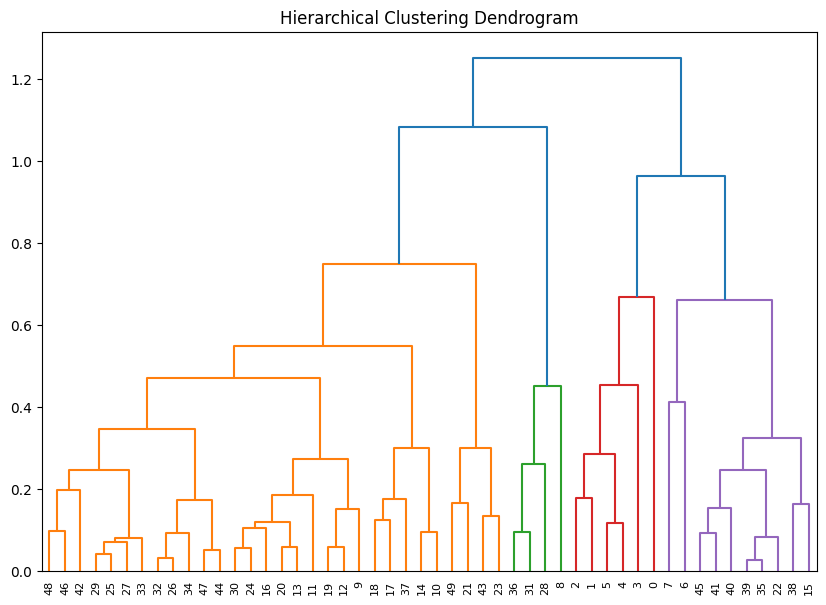

Cluster assignments:
   ServiceNo  WeightedParallelScore  PVChange  AvgDistanceToMRT  Clusters_KNN  \
0         67               0.780972 -1.259335          0.737742             2   
1         48               0.682618 -0.602706          0.773233             2   
2        107               0.656574 -0.055335          0.745774             2   
3          2               0.627249 -0.097881          0.848269             2   
4        133               0.584443 -0.178495          0.751249             2   
5        170               0.571120 -0.490143          0.772111             2   
6        190               0.549306 -0.675090          0.702800             3   
7         36               0.546066  1.147261          0.668416             3   
8         26               0.536735 -2.429445          0.897184             1   
9        851               0.492411 -0.441138          0.774226             3   
10        13               0.484494 -0.754651          0.885310             1   
11     

In [160]:
# Perform hierarchical clustering
linked = linkage(features_scaled, method='complete')
# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

# Cut the dendrogram to form clusters
num_clusters = 5
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Step 5: Add cluster labels to your original DataFrame
top_50_features['Cluster_HC'] = cluster_labels-1

# Step 6: Analyze the clusters
print("Cluster assignments:")
print(top_50_features)


In [161]:
top_50_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN,Cluster_HC
0,67,0.780972,-1.259335,0.737742,2,1
1,48,0.682618,-0.602706,0.773233,2,1
2,107,0.656574,-0.055335,0.745774,2,1
3,2,0.627249,-0.097881,0.848269,2,1
4,133,0.584443,-0.178495,0.751249,2,1
5,170,0.571120,-0.490143,0.772111,2,1
6,190,0.549306,-0.675090,0.702800,3,0
7,36,0.546066,1.147261,0.668416,3,0
8,26,0.536735,-2.429445,0.897184,1,2
9,851,0.492411,-0.441138,0.774226,3,4


### Hierarchical Clustering with top 20 bus services

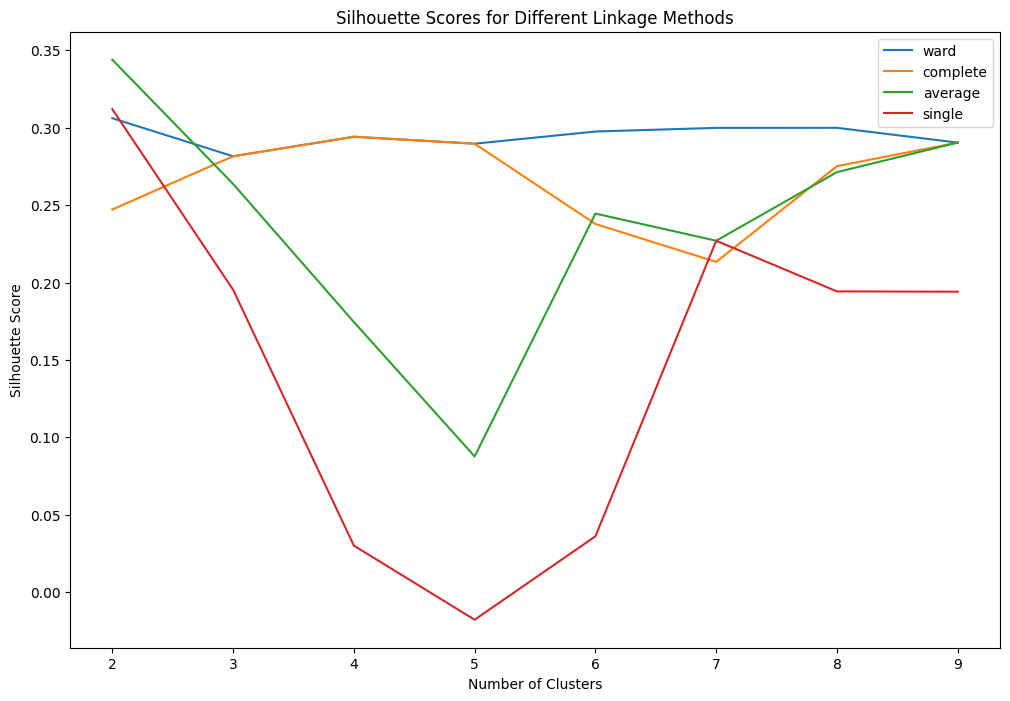

In [162]:
# Test different linkage methods and number of clusters
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores = {}

for method in linkage_methods:
    linked = linkage(features_scaled_20, method=method)
    silhouette_scores[method] = []

    # Test silhouette score for different number of clusters
    for k in range(2, 10):  # Test from 2 to 10 clusters
        cluster_labels = fcluster(linked, k, criterion='maxclust')
        score = silhouette_score(features_scaled_20, cluster_labels)
        silhouette_scores[method].append(score)

# Plot silhouette scores for each method
plt.figure(figsize=(12, 8))
for method in silhouette_scores:
    plt.plot(range(2, 10), silhouette_scores[method], label=method)

plt.title("Silhouette Scores for Different Linkage Methods")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()


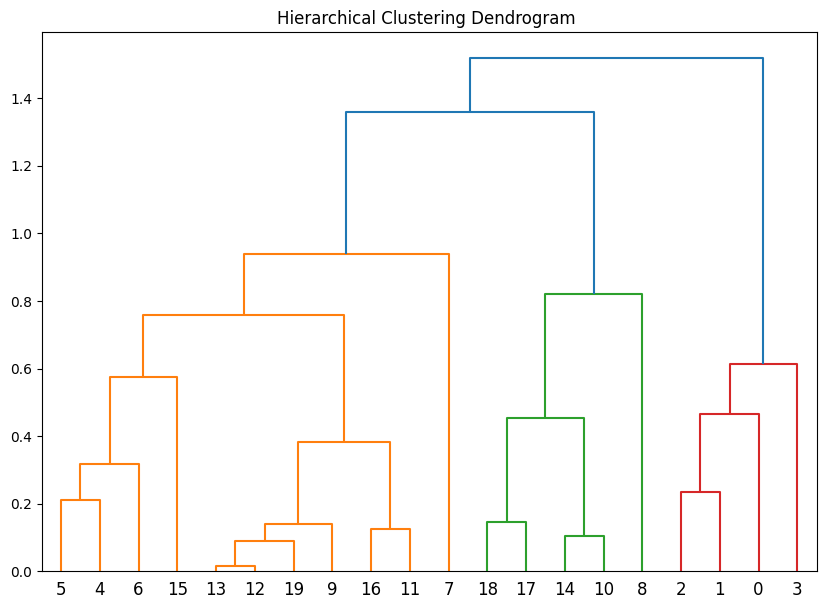

Cluster assignments:
   ServiceNo  WeightedParallelScore  PVChange  AvgDistanceToMRT  Clusters_KNN  \
0         67               0.780972 -1.203267          0.737742             2   
1         48               0.682618 -0.883289          0.773233             2   
2        107               0.656574 -0.145905          0.745774             2   
3          2               0.627249 -0.317594          0.848269             1   
4        133               0.584443 -0.007895          0.751249             1   
5        170               0.571120 -0.757153          0.772111             1   
6        190               0.549306 -0.548577          0.702800             1   
7         36               0.546066  1.493503          0.668416             0   
8         26               0.536735 -2.514463          0.897184             3   
9        851               0.492411 -0.286416          0.774226             1   
10        13               0.484494 -0.637731          0.885310             1   
11     

In [163]:
#Perform hierarchical clustering
linked = linkage(features_scaled_20, method='ward')

# Step 3: Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram ')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

# Step 4: Cut the dendrogram to form clusters
num_clusters = 5
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Step 5: Add cluster labels to your original DataFrame
top_20_features['Cluster_HC'] = cluster_labels-1

# Step 6: Analyze the clusters
print("Cluster assignments:")
print(top_20_features)

In [ ]:
data = top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']].values

# Parameters for clustering
k1 = 3 # Number of clusters for KMeans
k2 = 5 # Number of clusters for Hierarchical Clustering
final_k = 5 # Desired number of clusters for consensus clustering

# Run KMeans
kmeans = KMeans(n_clusters=k1, random_state=42)
kmeans_labels = kmeans.fit_predict(data)

# Run Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=k2)
hc_labels = hc.fit_predict(data)

# Create a co-association matrix
n_samples = len(data)
co_assoc_matrix = np.zeros((n_samples, n_samples))

# Increment matrix based on clustering results
for i in range(n_samples):
    for j in range(i, n_samples):
        if kmeans_labels[i] == kmeans_labels[j]:
            co_assoc_matrix[i, j] += 1
            co_assoc_matrix[j, i] += 1
        if hc_labels[i] == hc_labels[j]:
            co_assoc_matrix[i, j] += 1
            co_assoc_matrix[j, i] += 1

# Normalize by the number of clustering methods used (in this case, 2)
co_assoc_matrix /= 2

# Apply consensus clustering on the co-association matrix
consensus_clustering = AgglomerativeClustering(n_clusters=final_k, metric='precomputed', linkage='average')
final_labels = consensus_clustering.fit_predict(1 - co_assoc_matrix)

# Display the consensus clustering labels
print("Consensus Clustering Labels:", final_labels)

# Add the consensus labels to the DataFrame for analysis
top_20_features['Cluster_CC'] = final_labels

# Validation: ARI and NMI between consensus clustering and initial clustering methods
ari_kmeans = adjusted_rand_score(kmeans_labels, final_labels)
ari_hc = adjusted_rand_score(hc_labels, final_labels)
nmi_kmeans = normalized_mutual_info_score(kmeans_labels, final_labels)
nmi_hc = normalized_mutual_info_score(hc_labels, final_labels)

top_20_features['Cluster_CC'] = final_labels

print(f"ARI between Consensus and KMeans: {ari_kmeans}")
print(f"ARI between Consensus and Hierarchical Clustering: {ari_hc}")
print(f"NMI between Consensus and KMeans: {nmi_kmeans}")
print(f"NMI between Consensus and Hierarchical Clustering: {nmi_hc}")


Consensus Clustering Labels: [1 1 2 2 2 0 4 3 0 2 4 1 2 2 0 1 1 3 2 2]
ARI between Consensus and KMeans: 0.6287659145342241
ARI between Consensus and Hierarchical Clustering: 0.911284046692607
NMI between Consensus and KMeans: 0.7856250202470805
NMI between Consensus and Hierarchical Clustering: 0.918520546413608


In [180]:
top_20_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN,Cluster_HC,Cluster_CC
0,67,0.780972,-1.203267,0.737742,2,0,1
1,48,0.682618,-0.883289,0.773233,2,0,1
2,107,0.656574,-0.145905,0.745774,2,0,2
3,2,0.627249,-0.317594,0.848269,1,0,2
4,133,0.584443,-0.007895,0.751249,1,3,2
5,170,0.571120,-0.757153,0.772111,1,3,0
6,190,0.549306,-0.548577,0.702800,1,3,4
7,36,0.546066,1.493503,0.668416,0,4,3
8,26,0.536735,-2.514463,0.897184,1,2,0
9,851,0.492411,-0.286416,0.774226,1,3,2
